In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as stats2
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import inspect
import warnings
warnings.filterwarnings('ignore')


In [156]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_Geom": list( stats.geom.rvs(0.75, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


In [157]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        
        
        self.porcentaje_nulos_permitido=0.6

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")





    def plot_normailidad(self):

        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        aux_DF=self.cuanti
        self.df_inputado=self.df
        for i in aux_df:
            nulos=aux_DF[i].isna().sum()
            total=len(aux_DF[i])
            porcentaje=nulos/total
            if ((nulos>0) and (porcentaje<self.porcentaje_nulos_permitido)):
                percen=aux_DF[i].quantile([0.2,0.8]).to_list()
                self.df_inputado[i]=aux_DF[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    





    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        
    def fit_discrete(self,datos):

        # self.discreta

        mean = datos.mean()
        var = datos.var()
        likelihoods = {}  
        log_likelihoods = {}

        p = 1 - mean / var  
        r = (1-p) * mean / p



        log_likelihoods['nbinom'] = datos.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

        lambda_ = mean

        log_likelihoods['poisson'] = datos.map(lambda val: stats.poisson.logpmf(val, lambda_)).sum()


        best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
        print("**** Best fit between poisson and nbinorm :", best_fit)
        

        if (best_fit=='poisson'):
            plt.hist(datos, bins=int(np.max(datos)), density=True, alpha=0.5)

            mean = datos.mean()
            var = datos.var()


            def loss_function_poisson(params, datos_in):

                mu = params[0]

                loss = 0

                for i in range(len(datos_in)):

                    loglikelihood = stats.poisson.logpmf(datos_in[i], mu)

                    loss_to_add = -loglikelihood

                    loss += loss_to_add

                return(loss)




            params0 = np.array([20])
            minimum = stats2.optimize.fmin(loss_function_poisson, params0, args=(datos,))

            mu_fit = minimum[0]

            print("***********  The best mu_fit is:  ",  mu_fit)

            x = list(range(int(np.min(datos)), int(np.max(datos))+1))
            plt.scatter(x, stats.poisson.pmf(x, mu_fit),color="red")
            plt.show()   

            print("\n\n Otras variables discretas:  ",  self.discreta)


    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

            
        


# CREACIÓN DE LA CLASE

In [158]:
ejemplo=DF_exploracion(df_prueba)


In [159]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [160]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 995 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.005 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 12 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 18 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Geom 
|   - Tipo de dato: int64 
|   - Valores repetidos: 6 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0

## Creación de variables dummys a traves de dicotómicas

In [161]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             0           1       0       1          1          0
1             1           0       0       1          1          0
2             1           0       0       1          0          1
3             1           0       1       0          1          0
4             0           1       0       1          0          1
..          ...         ...     ...     ...        ...        ...
995           1           0       1       0          0          1
996           1           0       0       1          0          1
997           0           1       1       0          0          1
998           0           1       1       0          1          0
999           0           1       1       0          0          1

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [162]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_Geom,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,s,m,0,0.776348,-0.620328,4,4,2,816.0,NaN,Grupo 5,Grupo 1,0,1,0,1,1,0
1,n,m,0,-1.604507,NaN,2,9,1,NaN,NaN,Grupo 1,Grupo 0,1,0,0,1,1,0
2,n,m,1,-1.762859,-0.276957,3,13,1,172.0,NaN,Grupo 2,Grupo 0,1,0,0,1,0,1
3,n,h,0,-0.658539,-1.361698,3,9,2,606.0,NaN,Grupo 4,Grupo 3,1,0,1,0,1,0
4,s,m,1,-0.598249,1.358392,4,13,2,50.0,NaN,Grupo 4,Grupo 2,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,n,h,1,-0.292887,0.044996,2,9,1,806.0,101.0,Grupo 3,Grupo 2,1,0,1,0,0,1
996,n,m,1,1.844375,-0.030132,1,9,3,969.0,859.0,Grupo 5,Grupo 1,1,0,0,1,0,1
997,s,h,1,0.125863,-0.563005,3,12,1,697.0,883.0,Grupo 4,Grupo 1,0,1,1,0,0,1
998,s,h,0,-0.607305,-0.251499,2,19,1,333.0,523.0,Grupo 3,Grupo 0,0,1,1,0,1,0


## Revisión de variables agrupadas automaticamente

In [163]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_Geom', 'Datos_F', 'Datos_G']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [164]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
           Datos_D     Datos_E  Datos_Poisson_1  Datos_Poisson_3     Datos_F  \
count  1000.000000  995.000000       1000.00000      1000.000000  993.000000   
mean     -0.074392    0.015545          3.92000        10.261000  504.516616   
std       0.999503    0.978060          1.95996         3.119713  285.893552   
min      -3.307463   -3.017478          0.00000         3.000000    0.000000   
25%      -0.738862   -0.610923          2.75000         8.000000  259.000000   
50%      -0.066825    0.031857          4.00000        10.000000  515.000000   
75%       0.637757    0.652654          5.00000        12.000000  751.000000   
max       3.460608    2.771623         11.00000        20.000000  994.000000   

          Datos_G  
count  989.000000  
mean   506.461072  
std    291.517046  
min      0.000000  
25%    262.000000  
50%    498.000000  
75%    771.000000  
max   

In [165]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_NO_ES ....................
n    0.502
s    0.498
Name: ES_NO_ES, dtype: float64


...........Frecuencia variable sexo ....................
m    0.5
h    0.5
Name: sexo, dtype: float64


...........Frecuencia variable Datos_C ....................
0    0.526
1    0.474
Name: Datos_C, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_Geom ....................
1    0.752
2    0.172
3    0.055
4    0.010
5    0.008
6    0.003
Name: Datos_Geom, dtype: float64


...........Frecuencia variable Datos_cate_A ....................
Grupo 5    0.183
Grupo 0    0.176
Grupo 2    0.163
Grupo 3    0.163
Grupo 4    0.160
Grupo 1    0.155
Name: Datos_cate_A, dtype: float64


...........Frecuencia variable Datos_cate_B ....................
Grupo 3    0.254
Grupo 2    0.250
Grupo 1    0.248
Grupo 0    0.248
Name: Datos_cate_B, dtype: float64



In [166]:
ejemplo.cross_var_cualis_con_ciantis()



*************** TABAL DE VARIABLES CATEGORICAS Datos_Geom y Datos_cate_A con valores de Datos_D MEDIA *********************
 
Datos_cate_A   Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
Datos_Geom                                                              
1            -0.015413 -0.172554 -0.054883 -0.156871 -0.141939  0.009197
2            -0.261618 -0.032550  0.157507 -0.243071  0.026442  0.110184
3            -0.380462  0.135662 -0.440220  0.307489  0.214401 -0.181347
4            -0.904219  2.056297  0.401291  0.219138       NaN  0.348474
5            -0.521409  0.114890       NaN -0.570625  0.830772 -0.730150
6                  NaN -0.363768       NaN  1.008976       NaN       NaN





*************** TABAL DE VARIABLES CATEGORICAS Datos_Geom y Datos_cate_A con valores de Datos_E MEDIA *********************
 
Datos_cate_A   Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
Datos_Geom                                                              
1          

## Variables normales y no normales

In [167]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_1  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_1 y test Shapiro < 0.05
ShapiroResult(statistic=0.9662261605262756, pvalue=1.7993775008407278e-14)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_3  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_3 y test Shapiro < 0.05
ShapiroResult(statistic=0.9842157363891602, pvalue=6.315316714022856e-09)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_NO_ES y Datos_Poisson_1  ++++++++++++++++++++++++++

Agrupado por ES_NO_ES y por Dat

## Agrupación normal por categoricas

In [168]:
ejemplo.normal_grupos_cate

[['Datos_Geom', 'Datos_Poisson_1'],
 ['Datos_Geom', 'Datos_Poisson_1'],
 ['Datos_Geom', 'Datos_Poisson_1'],
 ['Datos_Geom', 'Datos_Poisson_3'],
 ['Datos_Geom', 'Datos_Poisson_3'],
 ['Datos_Geom', 'Datos_Poisson_3'],
 ['Datos_Geom', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cat

## Agrupación normalidad por dicotomicas

In [169]:
ejemplo.normal_grupos_dico

[['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_3']]

## Inputar datos en columnas variables cuantitativas

In [170]:
df_prueba[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,-0.620328,816.0,NaN
1,NaN,NaN,NaN
2,-0.276957,172.0,NaN
3,-1.361698,606.0,NaN
4,1.358392,50.0,NaN
...,...,...,...
995,0.044996,806.0,101.0
996,-0.030132,969.0,859.0
997,-0.563005,697.0,883.0
998,-0.251499,333.0,523.0


In [171]:
ejemplo.nulos()


- Se han inputado 5 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.005) 


- Se han inputado 7 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.007) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.011) 



In [172]:
ejemplo.df_inputado[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,-0.620328,816.0,679.0
1,1.000000,478.0,265.0
2,-0.276957,172.0,679.0
3,-1.361698,606.0,463.0
4,1.358392,50.0,721.0
...,...,...,...
995,0.044996,806.0,101.0
996,-0.030132,969.0,859.0
997,-0.563005,697.0,883.0
998,-0.251499,333.0,523.0


## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)


 ******************** Variable: Datos_D ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters that are outside the range allowed by the distribution.

Error al tratar de ajustar la distribución reciprocal
Optimization converged to parameters that are outside the range allowed by the distribution.



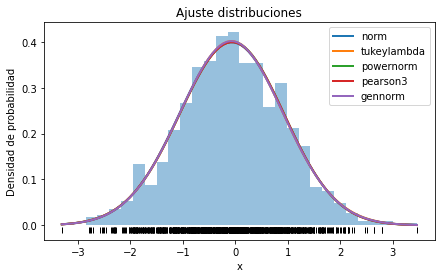



  distribucion  log_likelihood          aic          bic  n_parametros  \
0         norm    -1417.940833  2839.881666  2849.697177             2   
1  tukeylambda    -1417.869105  2841.738210  2856.461476             3   
2    powernorm    -1417.889752  2841.779504  2856.502770             3   
3     pearson3    -1417.903567  2841.807134  2856.530400             3   
4      gennorm    -1417.925391  2841.850783  2856.574048             3   

                                          parametros  
0  {'loc': -0.07439195124965138, 'scale': 0.99900...  
1  {'lam': 0.1359664984468993, 'loc': -0.07220396...  
2  {'c': 1.1313208924955482, 'loc': 0.03883974710...  
3  {'skew': -0.02118943981542276, 'loc': -0.07440...  
4  {'beta': 1.9748293065096632, 'loc': -0.0743134...  

------------------------------------------------------------------


 ******************** Variable: Datos_E ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters

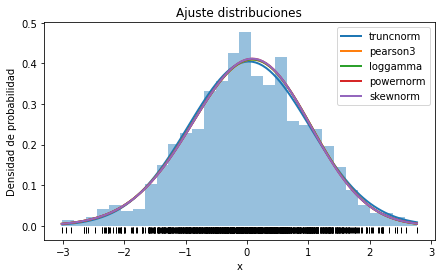



  distribucion  log_likelihood          aic          bic  n_parametros  \
0    truncnorm    -1391.802052  2791.604103  2811.235125             4   
1     pearson3    -1393.625134  2793.250268  2807.973534             3   
2     loggamma    -1393.656206  2793.312412  2808.035678             3   
3    powernorm    -1393.739599  2793.479199  2808.202465             3   
4     skewnorm    -1393.739635  2793.479270  2808.202536             3   

                                          parametros  
0  {'a': -3.117741208238515, 'b': 2.7687315014829...  
1  {'skew': -0.14414325633726255, 'loc': 0.018482...  
2  {'c': 50.11315787114807, 'loc': -26.8406480336...  
3  {'c': 2.0094656586687245, 'loc': 0.69082732161...  
4  {'a': -1.0020004553945268, 'loc': 0.6868857381...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_1 ******************** 



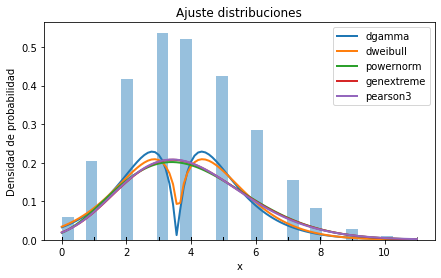



  distribucion  log_likelihood          aic          bic  n_parametros  \
0       dgamma    -2057.992013  4121.984025  4136.707291             3   
1     dweibull    -2071.999192  4149.998385  4164.721651             3   
2    powernorm    -2072.643109  4151.286217  4166.009483             3   
3   genextreme    -2073.922635  4153.845269  4168.568535             3   
4     pearson3    -2074.458105  4154.916209  4169.639475             3   

                                          parametros  
0  {'a': 1.916691152205324, 'loc': 3.567251598566...  
1  {'c': 1.4178993434625804, 'loc': 3.60936406261...  
2  {'c': 0.06531300577055105, 'loc': 0.9012021026...  
3  {'c': 0.15606204317365535, 'loc': 3.1233008628...  
4  {'skew': 0.5061631945827711, 'loc': 3.91997258...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_3 ******************** 



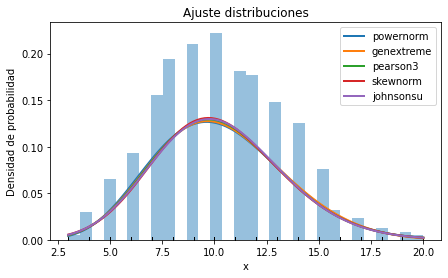



  distribucion  log_likelihood          aic          bic  n_parametros  \
0    powernorm    -2546.635289  5099.270578  5113.993844             3   
1   genextreme    -2546.893409  5099.786818  5114.510084             3   
2     pearson3    -2548.442756  5102.885512  5117.608778             3   
3     skewnorm    -2550.037856  5106.075711  5120.798977             3   
4    johnsonsu    -2549.084066  5106.168132  5125.799153             4   

                                          parametros  
0  {'c': 0.14111748643936867, 'loc': 6.2623466196...  
1  {'c': 0.19433249933781493, 'loc': 9.0386647008...  
2  {'skew': 0.35470463307909983, 'loc': 10.260968...  
3  {'a': 1.5592095213069015, 'loc': 7.42077717826...  
4  {'a': -13.896784129385033, 'b': 8.472239822810...  

------------------------------------------------------------------


 ******************** Variable: Datos_F ******************** 



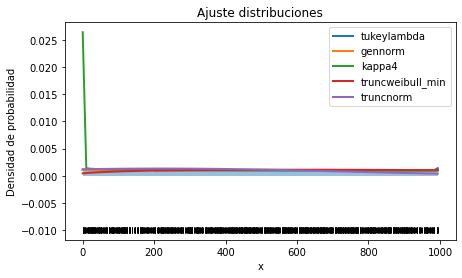



       distribucion  log_likelihood           aic           bic  n_parametros  \
0       tukeylambda    -6901.254708  13808.509416  13823.232682             3   
1           gennorm    -6901.737362  13809.474723  13824.197989             3   
2            kappa4    -6901.070967  13810.141934  13829.772955             4   
3  truncweibull_min    -6921.798010  13853.596020  13878.134796             5   
4         truncnorm    -6965.449177  13938.898354  13958.529375             4   

                                          parametros  
0  {'lam': 1.027766533963535, 'loc': 496.95308851...  
1  {'beta': 86507637.36853385, 'loc': 496.9999965...  
2  {'h': 1.101018797167058, 'k': 1.00481634049732...  
3  {'c': 1.3710764458718825, 'a': 0.0013897966953...  
4  {'a': -0.4520322444666054, 'b': 1.573265996773...  

------------------------------------------------------------------


 ******************** Variable: Datos_G ******************** 



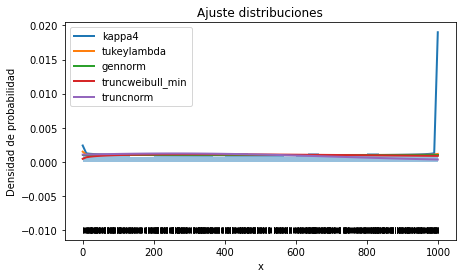



       distribucion  log_likelihood           aic           bic  n_parametros  \
0            kappa4    -6902.801626  13813.603252  13833.234273             4   
1       tukeylambda    -6906.218102  13818.436203  13833.159469             3   
2           gennorm    -6906.754834  13819.509667  13834.232933             3   
3  truncweibull_min    -6911.789817  13833.579635  13858.118411             5   
4         truncnorm    -7056.722551  14121.445102  14141.076123             4   

                                          parametros  
0  {'h': 1.0911492574010377, 'k': 1.0930767395431...  
1  {'lam': 1.0367499322345333, 'loc': 499.5090501...  
2  {'beta': 257806519.247358, 'loc': 499.50000212...  
3  {'c': 1.1999269530213015, 'a': 0.0009694164996...  
4  {'a': -0.5619118742188756, 'b': 58754.31574137...  

------------------------------------------------------------------



In [173]:
ejemplo.comparar_distribuciones_caunti_cont()

## Ajustar a distribuciones variables discretas (No puede haber nulos) (Solo poisson y binomial)

In [174]:
ejemplo.fit_discrete(df_prueba["Datos_Poisson_1"])

**** Best fit between poisson and nbinorm : nbinom


## Quitar outlaiers

# PLOTS

In [175]:
#ejemplo.todos_plots()

In [176]:
# ejemplo.plot_bigotes()

In [177]:
# ejemplo.plot_barras()

In [178]:
# ejemplo.plot_corr()

In [179]:
# ejemplo.violines()

In [180]:
# ejemplo.plot_normailidad()

# TEST ESTADISTICOS

## Chi2

In [181]:
ejemplo.Chi()


-------------- Chi2 entre ES_NO_ES y sexo ----------------
p: 0.8993423875828498 


-------------- Chi2 entre ES_NO_ES y Datos_C ----------------
p: 0.1615478132424502 


-------------- Chi2 entre sexo y Datos_C ----------------
p: 0.8992075511407842 



## T_student

# Wilconxon

## Anova

In [182]:
ejemplo.anova()


----------- ANOVA Categoria Datos_Geom y variable continua Datos_D ----------

                sum_sq     df        F    PR(>F)
Datos_Geom    0.356935    1.0  0.35706  0.550279
Residual    997.649654  998.0      NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_E ----------

                sum_sq     df         F    PR(>F)
Datos_Geom    0.386418    1.0  0.404505  0.524918
Residual    953.374244  998.0       NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_Poisson_1 ----------

                sum_sq     df         F   PR(>F)
Datos_Geom     1.80925    1.0  0.470733  0.49281
Residual    3835.79075  998.0       NaN      NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_Poisson_3 ----------

                 sum_sq     df         F    PR(>F)
Datos_Geom    20.703311    1.0  2.129616  0.144792
Residual    9702.175689  998.0       NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_F